In [21]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## ODE functions

In [22]:
class SpiralFunctionExample(nn.Module):
    def __init__(self, W=torch.Tensor([[-0.1, -1.0], [1.0, -0.1]])):
        super().__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        return self.lin(x)


class RandomFunctionExample(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(torch.randn(2, 2) / 2)

    def forward(self, t, x):
        return self.lin(x)


class LinearODEF(nn.Module):
    def __init__(self, W, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(sefl, t, x):
        return sefl.lin(x)

## Neural ODE

In [23]:
class NeuralODE(nn.Module):
    def __init__(self, func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.odefunc = func

    def forward(self, y0, t):
        return odeint(self.odefunc, y0, t, options={"dtype": torch.float32})

In [24]:
def to_np(x):
    return x.detach().cpu().numpy()


def plot_trajectories(
    obs=None, times=None, trajs=None, curr_epoch=None, save=None, figsize=(16, 8)
):
    if curr_epoch is None:
        raise ValueError("curr_epoch must not be None")

    plt.figure(figsize=figsize)
    plt.text(
        0.02,
        0.98,
        f"Current Epoch: {curr_epoch}",
        transform=plt.gca().transAxes,
        fontsize=14,
        verticalalignment="top",
    )
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t, cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [25]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable

# DEVICE = (
#     torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# )
DEVICE = torch.device("cpu")

ode_true = NeuralODE(SpiralFunctionExample()).to(DEVICE)
ode_train = NeuralODE(RandomFunctionExample()).to(DEVICE)

z0 = Variable(torch.Tensor([[0.6, 0.3]])).to(DEVICE)

t_max = 6.29 * 5
n_points = 200

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack([index_np], dtype=int)
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np])

times = torch.from_numpy(times_np).to(torch.float32)
obs = ode_true(z0, times).detach()
obs += torch.randn_like(obs) * 0.01

# Get trajectory of random timespan
min_delta_time = 1.0
max_delta_time = 5.0
max_points_num = 32


def create_batch():
    t0 = np.random.uniform(0, t_max - max_delta_time)
    t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

    idx = sorted(
        np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[
            :max_points_num
        ]
    )

    obs_ = obs[idx]
    ts_ = times[idx]
    return obs_, ts_


# # Train Neural ODE
# optimizer = torch.optim.Adam(ode_train.parameters(), lr=1e-2)
# for i in range(3000):
#     obs_, ts_ = create_batch()
#     optimizer.zero_grad()
#     z_ = ode_train(obs_[0].to(DEVICE), ts_.to(DEVICE))
#     loss = F.mse_loss(z_, obs_.detach())
#     loss.backward()
#     optimizer.step()
#     if (i + 1) % 20 == 0:
#         z_p = ode_train(z0, times)
#         plot_trajectories(
#             obs=[obs],
#             times=[times],
#             trajs=[z_p],
#             curr_epoch=i + 1,
#             # save=f"./plot/Linear_NODE/{i + 1}.png",
#         )
#         clear_output(wait=True)

In [26]:
# import imageio

# images = []
# for i in range(3000):
#     if (i + 1) % 20 == 0:
#         images.append(imageio.imread(f"./plot/Linear_NODE/{i + 1}.png"))
# imageio.mimsave("./plot/Linear_NODE/animation.gif", images, fps=20)

## Neural ODVAE

ODVE - neural Ordinary Differential Variational Auto-Encoder

---

A generative model through sampling procedure:
$$
z_{t_0} \sim \mathcal{N}(0, I)
$$

$$
z_{t_1}, z_{t_2},...,z_{t_M} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_M)
$$

$$
\text{each } x_{t_i} \sim p(x \mid z_{t_i};\theta_x)
$$

Computation graph of the latent ODE model can be depicted like this

![vae_model](../assets/Xnip2025-01-18_16-29-43.png)
<div align="center">Figure from the original paper</div>

In [27]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim + 1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2 * latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.0
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, : self.latent_dim]
        z0_log_var = z0[:, self.latent_dim :]
        return z0_mean, z0_log_var  ## both (n_timestamps, n_samples, latent_dim)

In [28]:
class NNODEF(nn.Module):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim + 1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, t, x):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [29]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t)  ## (n_timestamps, batch_size, 3)
        print(f"wtf:{zs.shape}")

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [30]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim: int = 2, hidden_dim: int = 64, latent_dim: int = 6):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t) 
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t[:, 0].view(-1))
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t[:, 0].view(-1))
        return x_p

In [31]:
t_max = 6.29 * 5
n_points = 200
noise_std = 0.02

num_spirals = 50

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack([index_np], dtype=int)
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)  ## (200, 1000)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  ## (1000, 2)

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 = 1.0 * normal01.sample((num_spirals,)).abs()


xs_list = []
for i in range(num_spirals):
    if i % 2 == 1:  #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(torch.Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i : i + 1], times[:, i : i + 1].view(-1))
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

In [32]:
samp_ts.dtype

torch.float32

In [33]:
print(orig_trajs.shape)
print(samp_trajs.shape)
print(samp_ts.shape)

torch.Size([200, 50, 2])
torch.Size([200, 50, 2])
torch.Size([200, 50, 1])


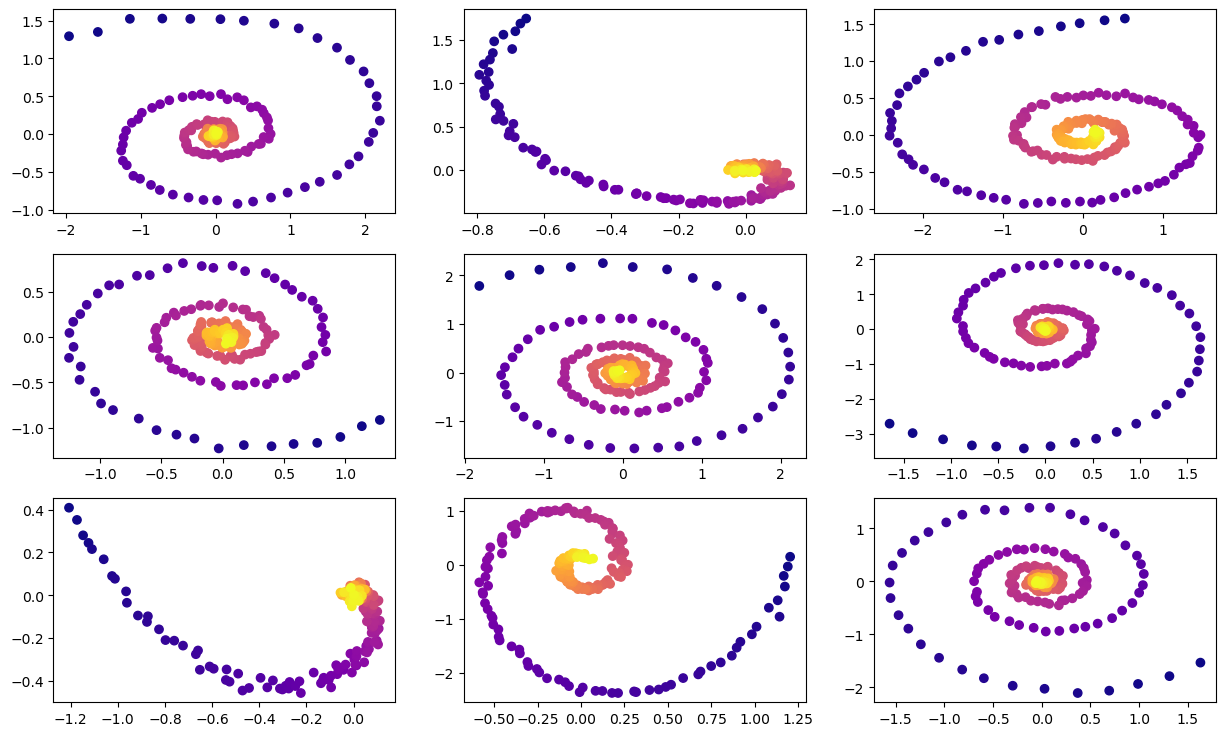

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(
        samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i], cmap=cm.plasma
    )
plt.show()

In [35]:
odevae = ODEVAE(2, 64, 6)
if torch.cuda.is_available():
    odevae.cuda()
optim = torch.optim.Adam(odevae.parameters(), betas=(0.9, 0.999), lr=0.001)

In [36]:
print(odevae)

ODEVAE(
  (encoder): RNNEncoder(
    (rnn): GRU(3, 64)
    (hid2lat): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder): NeuralODEDecoder(
    (ode): NeuralODE(
      (odefunc): NNODEF(
        (lin1): Linear(in_features=6, out_features=64, bias=True)
        (lin2): Linear(in_features=64, out_features=64, bias=True)
        (lin3): Linear(in_features=64, out_features=6, bias=True)
        (elu): ELU(alpha=1.0, inplace=True)
      )
    )
    (l2h): Linear(in_features=6, out_features=64, bias=True)
    (h2o): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [37]:
def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:  ## 截取整个时序范围内的一段 t0‘-t1'
            t0_idx = np.random.multinomial(
                1, [1.0 / (time_len - n_sample)] * (time_len - n_sample)
            )
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size * i, batch_size * (i + 1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

In [38]:
samp_trajs.shape

torch.Size([200, 50, 2])

torch.Size([100, 10, 2])
torch.Size([100, 10, 1])
wtf:torch.Size([100, 10, 6])
torch.Size([50, 10, 2])
torch.Size([50, 10, 1])
wtf:torch.Size([50, 10, 6])
torch.Size([100, 10, 2])
torch.Size([100, 10, 1])
wtf:torch.Size([100, 10, 6])
torch.Size([100, 10, 2])
torch.Size([100, 10, 1])
wtf:torch.Size([100, 10, 6])
torch.Size([50, 10, 2])
torch.Size([50, 10, 1])
wtf:torch.Size([50, 10, 6])
Epoch 50
wtf:torch.Size([200, 50, 6])


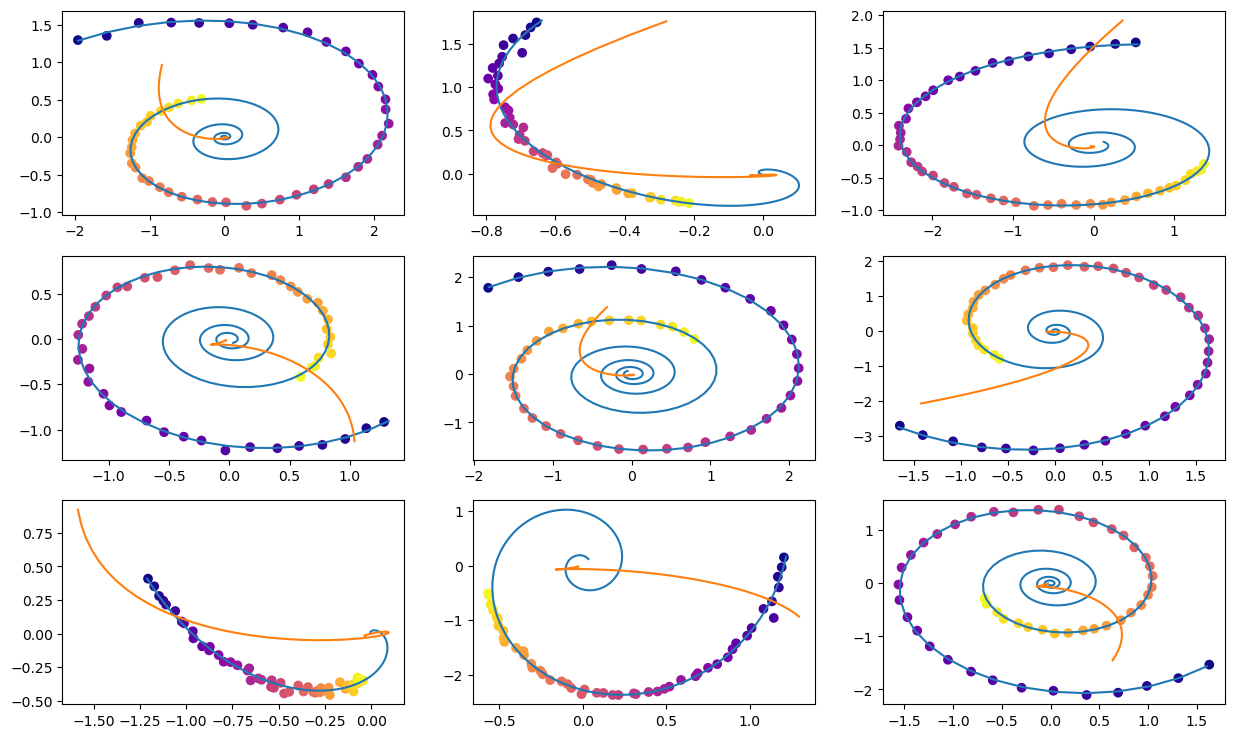

529.2421997070312 382.5357360839844


In [39]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
odevae.to(device)

n_epochs = 50
batch_size = 10

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx : plot_traj_idx + 1]
plot_obs = samp_trajs[:, plot_traj_idx : plot_traj_idx + 1]
plot_ts = samp_ts[:, plot_traj_idx : plot_traj_idx + 1]

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if torch.cuda.is_available():
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]
        print(x.shape)
        print(t.shape)

        x_p, z, z_mean, z_log_var = odevae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x - x_p) ** 2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx+1}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if torch.cuda.is_available():
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(odevae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(
            to_np(seed_trajs[:, i, 0]),
            to_np(seed_trajs[:, i, 1]),
            c=to_np(ts[frm:to_seed, i, 0]),
            cmap=cm.plasma,
        )
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

wtf:torch.Size([200, 10, 6])


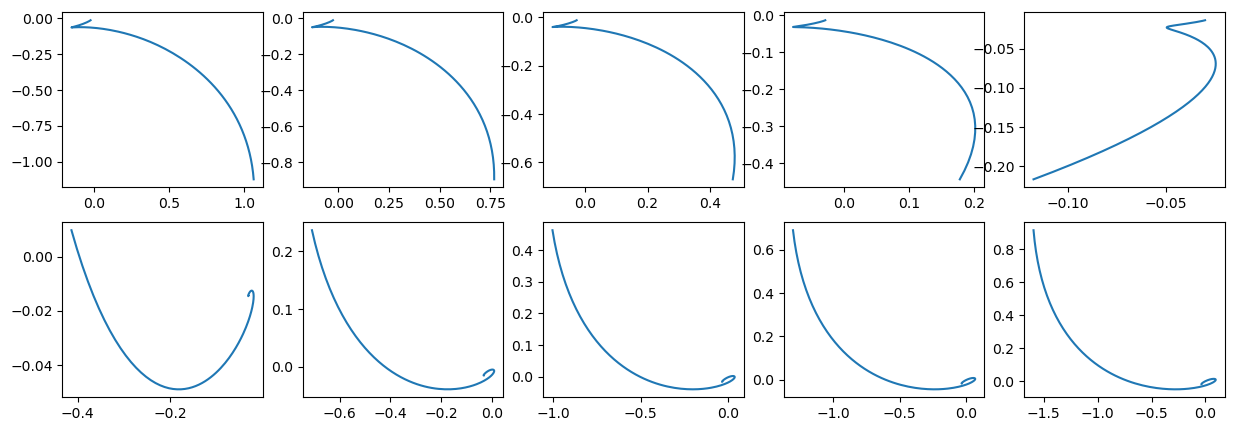

In [41]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = torch.Tensor(np.linspace(0.0, 1.0, 10)[:, None])
vae = odevae
if torch.cuda.is_available():
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx : spiral_0_idx + 1, :]
spiral_1 = orig_trajs[:, spiral_1_idx : spiral_1_idx + 1, :]
ts_0 = samp_ts[:, spiral_0_idx : spiral_0_idx + 1, :]
ts_1 = samp_ts[:, spiral_1_idx : spiral_1_idx + 1, :]
if torch.cuda.is_available():
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6 * np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None]
if torch.cuda.is_available():
    t.cuda()
hom_gen_trajs = vae.decoder(homotopy_z, t[:, 0].view(-1))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()